In [2]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import collections
from scipy.stats.mstats import zscore

In [87]:
#ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImages.pkl"
ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImagesBottomUp.pkl"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/mediumImages.pkl"
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [88]:
len(imgList)

1000

In [89]:
AMImages = "/datasets/sagarj/streetView/Transform_1000/"
#AMImages = "/datasets/sagarj/streetView/Transform_Medium/"

In [90]:
files = os.listdir(AMImages)

In [91]:
files[1].split('_')

['513d7e35fdc9f03587007365', '0001', '0.414554', '.jpg']

In [92]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [93]:
len(filesMap.keys())

1000

In [94]:
for row in imgList:
    if row[1]['key'] in filesMap.keys():
        filesMap[row[1]['key']]['origPath'] = row[1]['path']
        filesMap[row[1]['key']]['label'] = row[1]['label']

In [95]:
filesMap[filesMap.keys()[1]]

{'act': '0.462293',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg'}

In [96]:
#Image(filesMap['513d9f45fdc9f035870086b4']['origPath'])

In [97]:
#Image(filesMap['513d9f45fdc9f035870086b4']['path'])

In [98]:
#filesMap['513d9f45fdc9f035870086b4']['changeLabel']

In [99]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['path'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = transformer.preprocess('data',caffe.io.load_image(path))
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

def getPlaces(path):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    path = path.strip()
    if not os.path.exists(path):
        featArray = np.zeros((1,4096))
    else:
        im = transformer.preprocess('data',caffe.io.load_image(path))
        net.blobs['data'].data[...] = im - meanMat
        net.forward()
        featArray = net.blobs['prob'].data.copy()
    return featArray

In [100]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

In [101]:
transformedFilesMap = getFeatMatrix(filesMap)

In [102]:
transformedFilesMap[transformedFilesMap.keys()[151]]

{'act': '1.21166',
 'changeLabel': '0',
 'label': 1,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f448a4fdc9f065f00040ba.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/50f448a4fdc9f065f00040ba_0000_1.21166_.jpg',
 'placesFeats': array([[ 0.        ,  0.72337198,  0.        , ...,  0.20558679,
          0.14917183,  0.        ]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [103]:
# with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
#     imagePaths = f.readlines()

In [104]:
#len(imagePaths)

In [105]:
#sampledpaths[1]

In [106]:
# sampledpaths = random.sample(imagePaths , 5000)

In [107]:
# with open("../Data/sampledSegnetImages.pkl",'wb') as f:
#     pickle.dump(sampledpaths,f,protocol=pickle.HIGHEST_PROTOCOL)

In [157]:
with open('../Data/testSegnetFeatures.pkl', 'rb') as handle:
    testSegnetLabels = pickle.load(handle)
#with open('../Data/retrievalSegnetLabelsTextures.pkl', 'rb') as handle:
#    segnetLabels = pickle.load(handle)

with open('../Data/fringe1000SegnetFeatures.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)


In [158]:
with open('../Data/testImages.pkl', 'rb') as handle:
    testImages = pickle.load(handle)

In [159]:
testKeys = [i[1]['key']  for i in testImages]
transformedKeys = [k for k in filesMap]

In [160]:
common = [k for k in transformedKeys if k in testKeys]

In [161]:
len(common)

479

In [162]:
testImages[1]

('513d7ffefdc9f0358700767c',
 {'key': '513d7ffefdc9f0358700767c',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7ffefdc9f0358700767c.jpg',
  'trueSkill': [30.94110828649425]})

In [163]:
filteredTestImages = []
for k in testImages:
    if k[0] not in common:
        filteredTestImages.append(k)

In [164]:
filteredTestImages[0]

('50f447d2fdc9f065f0003a7d',
 {'key': '50f447d2fdc9f065f0003a7d',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f447d2fdc9f065f0003a7d.jpg',
  'trueSkill': [30.93538936269406]})

In [165]:
dataFileMap = {}
for p in filteredTestImages:
    path = p[1]['path']
    key = p[1]['key']
    dataFileMap[key] = {}
    dataFileMap[key]['path'] = path

In [166]:
dataFileMap[dataFileMap.keys()[1]]

{'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513e6297fdc9f0358700b6fd.jpg'}

In [167]:
retreivalFileMap = getFeatMatrix(dataFileMap)

# End shitty zone now. the next sections are about matching

In [168]:
from scipy.spatial import distance
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        #distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        distanceMapper[k][i] = distance.euclidean(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])

In [169]:
len(distanceMapper.keys())

1000

In [170]:
#distanceMapper[distanceMapper.keys()[0]]

In [171]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [172]:
top5s[top5s.keys()[1]]

[('50f60c41beb2fed910000174', 21.436391830444336),
 ('513d7cb7fdc9f03587006faa', 21.553407669067383),
 ('50f561bcfdc9f065f0005640', 21.70827865600586),
 ('50f55eaffdc9f065f0004dfa', 22.45761489868164),
 ('50f5eeb0fdc9f065f0009006', 22.798471450805664)]

In [173]:
# index = pd.Series(range(len(filesMap.keys())))
# column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [174]:
filesMap[filesMap.keys()[1]]

{'act': '0.462293',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg',
 'path': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'placesFeats': array([[ 0.22105652,  0.61728495,  0.        , ...,  1.17217755,
          0.31463331,  0.        ]], dtype=float32)}

In [175]:
retreivedDf = {}

In [176]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5Paths = [dataFileMap[p[0]]['path'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    retreivedDf[k] = dict()
    retreivedDf[k] = {'key' : k , 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths]}

In [177]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['50f60c41beb2fed910000174',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f55eaffdc9f065f0004dfa',
   '50f5eeb0fdc9f065f0009006']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55eaffdc9f065f0004dfa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eeb0fdc9f065f0009006.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'key': '5140ca1cfdc9f0492600272f',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg'}

In [178]:
retreivedDf[retreivedDf.keys()[10]]['Top5Paths'][0]

['/work/sagarj/Work/BellLabs/streetview/PPImages/513d5fd9fdc9f03587003c47.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5e566fdc9f065f000683b.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eba2fdc9f065f000839e.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eb1ffdc9f065f0007ff3.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/514134dafdc9f049260047ea.jpg']

In [179]:
# for k in range(len(retreivedDf.keys()[:90])):
#     print retreivedDf[retreivedDf.keys()[k]]['XformPath']

In [186]:
k = 111#16 #16 #190 16 #15 #114 #54 #40 

In [187]:
retreivedDf[retreivedDf.keys()[k]]['XformPath']

'/datasets/sagarj/streetView/Transform_1000/513da091fdc9f035870089d6_0001_0.450974_.jpg'

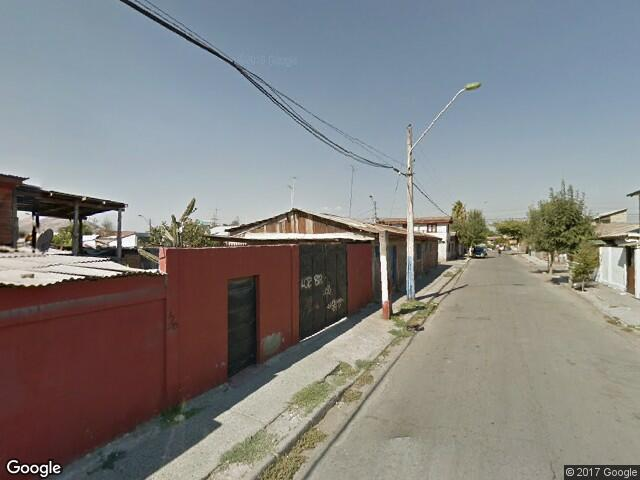

In [188]:
Image(retreivedDf[retreivedDf.keys()[k]]['origPath'])

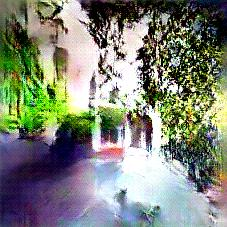

In [189]:
Image(retreivedDf[retreivedDf.keys()[k]]['XformPath'])

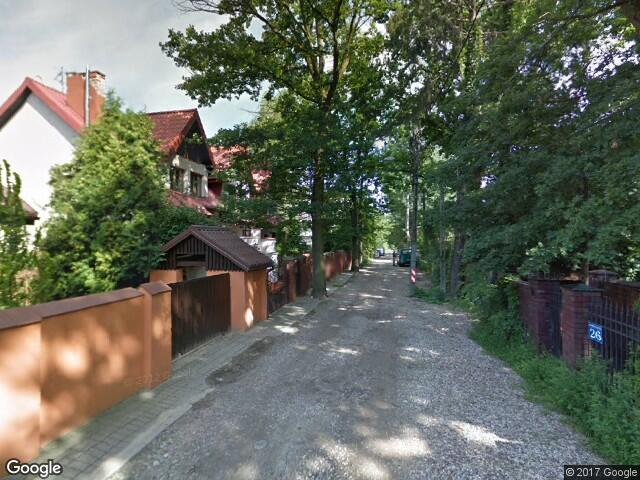

In [191]:
Image(retreivedDf[retreivedDf.keys()[k]]['Top5Paths'][0] [1])

In [192]:
# with open("../Data/retreivedfringeDataframe2.pkl" , 'wb') as f:
#     pickle.dump(retreivedDf , f , protocol=pickle.HIGHEST_PROTOCOL)

# After this step, run the segnet code to extract the right labeled pixel info

In [193]:
len(segnetLabels.keys()) , len(testSegnetLabels.keys())

(1000, 5000)

In [206]:
collections.Counter(np.squeeze(testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels']).flatten())

Counter({0.0: 53775,
         1.0: 28146,
         2.0: 141,
         3.0: 11,
         4.0: 36008,
         5.0: 27439,
         6.0: 12616,
         7.0: 710,
         8.0: 11057,
         9.0: 2309,
         10.0: 360,
         11.0: 228})

In [195]:
segnetLabels[segnetLabels.keys()[10]]

{'Building': array([[ 20.8520908 ,  20.4173409 ,  12.37873357,  20.54268808]]),
 'Road': array([[ 7.04119622,  7.22145275,  6.97192554,  6.85803324]]),
 'Sky': array([[ 0.59602063,  0.64952438,  0.71319086,  0.8061088 ]]),
 'Tree': array([[ 22.68622473,  21.43803048,  22.87747869,  23.16039738]]),
 'segnetLabels': array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  6., ...,  0.,  0.,  0.],
        [ 6.,  6.,  6., ...,  0.,  0.,  0.],
        ..., 
        [ 9.,  9.,  9., ...,  4.,  4.,  4.],
        [ 9.,  9.,  9., ...,  4.,  4.,  4.],
        [ 1.,  9.,  9., ...,  4.,  4.,  4.]], dtype=float32)}

In [196]:
retreivedDf[retreivedDf.keys()[101]]['Top5Keys'][0]

['514137dafdc9f0492600509c',
 '513d5749fdc9f0358700313d',
 '50f5e566fdc9f065f000683b',
 '50f447ccfdc9f065f00039e4',
 '5140c9d8fdc9f04926002668']

# This section is for calculating normalized ratios of the segnet labels

In [208]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[retreivedDf[k]['key']] = {}
    deltas[retreivedDf[k]['key']]['act'] = xformact
    deltas[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['top5'] = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:  
            if l in testSegnetLabels.keys():
                deltas[retreivedDf[k]['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(testSegnetLabels[l]['segnetLabels'].flatten())) , denom))
                
    
    
    
    
    

In [283]:
#deltas[deltas.keys()[1]]

In [210]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [211]:
# deltas[deltas.keys()[100]]['top5']
mean = {}
std = {}

scores = {}
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            if dim not in scores:
                scores[dim] = []
            scores[dim].append(ratios[dim])
#print scores.keys()
for k in scores:
    mean[k] = np.mean(scores[k])
    std[k] = np.std(scores[k])
    
print mean , std

{0.0: 0.20744820985792792, 1.0: 0.16081019328703705, 2.0: 0.0082522741999569247, 3.0: 0.0017503370081974378, 4.0: 0.11854665149424266, 5.0: 0.09640145601851853, 6.0: 0.31597640162037038, 7.0: 0.0020656176804274631, 8.0: 0.027250588933901761, 9.0: 0.055313662298845427, 10.0: 0.0065995219652746594, 11.0: 0.0032856018182794832} {0.0: 0.11536118389991398, 1.0: 0.14732821780294258, 2.0: 0.0085375749106289863, 3.0: 0.0043913072202167117, 4.0: 0.074512300930581116, 5.0: 0.061690297292687948, 6.0: 0.23153715986685885, 7.0: 0.0033624723414005329, 8.0: 0.03583122269362983, 9.0: 0.063489520619738102, 10.0: 0.015044166102852792, 11.0: 0.0091629468137058422}


In [212]:
# Find update Z scores in deltas:
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            orig = ratios[dim]
            Zscore = (orig - mean[dim])/std[dim]
            ratios[dim] = Zscore

In [233]:
## Get label wise dimensions for uglified and beautified images (top 1 image)

acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]

for k in deltas:
    #if deltas[k]['act'] > 0.1:
    #for c in deltas[k]['top5']:
    if len(deltas[k]['top5']) > 0:
        c = deltas[k]['top5'][0]
        action.append(deltas[k]['label'])
        acts.append(deltas[k]['act'])
        for dims in range(len(labels)):
            delta = 0.0
            if dims in c:
                delta = c[dims]
            labelDeltas[int(dims)].append(delta)

In [234]:
dim = 6

1000 1000 1000


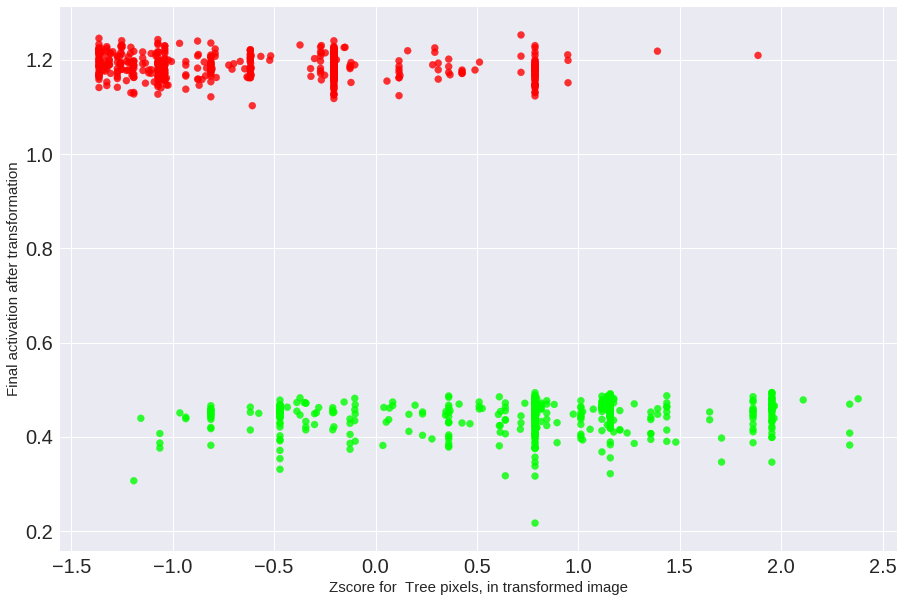

In [235]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]

colors = [colorPallet[action[i]] for i in range(len(action)) if labelDeltas[dim][i] != 0.0 ]
delRatio = [labelDeltas[dim][i] for i in range(len(labelDeltas[dim])) if labelDeltas[dim][i] != 0.0]
delActs = [acts[i] for i in range(len(acts)) if labelDeltas[dim][i] != 0.0 ]
print len(delRatio) , len(delActs) , len(colors)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( delRatio , delActs,  alpha=0.8 , c = colors)
#plt.legend(['Uglified' , 'Beautified'])
plt.show()

In [236]:
len(labelDeltas[0])

1000

Extract Beauty and ugly scores for each image based on action (uglified or beautified

In [237]:
beautyDim = []


for j in range(len(labels)):
    beautyDim.append([labelDeltas[j][i] for i in range(len(action)) if (action[i]==1 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==1 ])

In [238]:
uglyDim = []

for j in range(len(labels)):
    uglyDim.append([labelDeltas[j][i] for i in range(len(action)) if(action[i]==0 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==0 ])

In [239]:
print len(beautyDim[11])

423


In [240]:
print labels

['Sky', 'Building', 'Pole', 'Road Marking', 'Road', 'Pavement', 'Tree', 'Sign Symbol', 'Fence', 'Vehicle', 'Pedestrian', 'Bike']


In [249]:
dim = 9

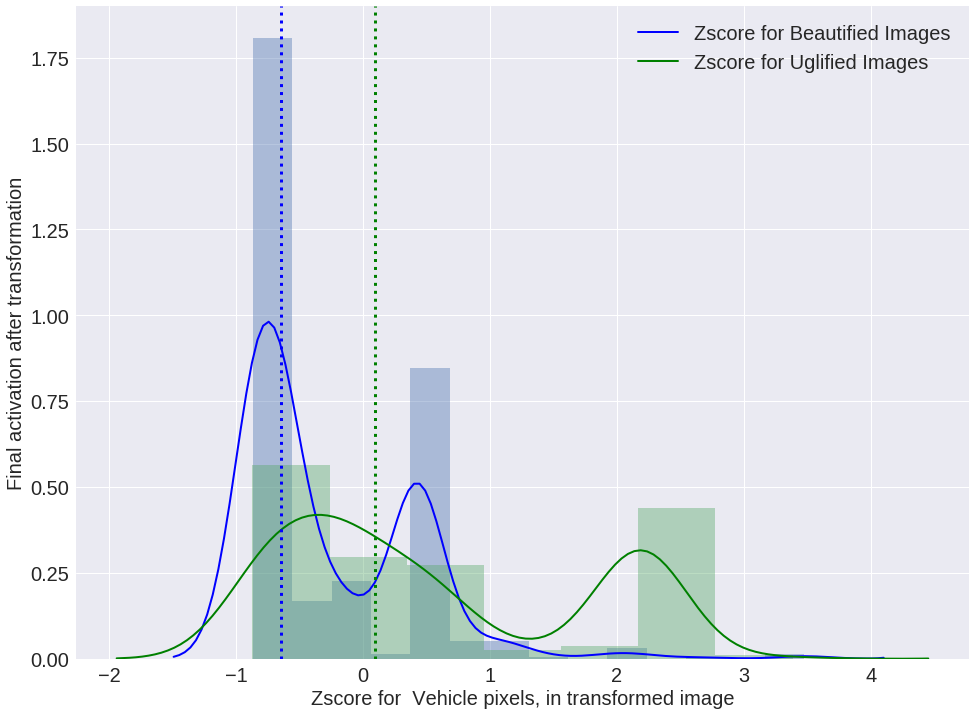

In [250]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyDim[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyDim[dim] , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Final activation after transformation" , fontsize = 20 )

In [251]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['50f60c41beb2fed910000174',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f55eaffdc9f065f0004dfa',
   '50f5eeb0fdc9f065f0009006']],
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f55eaffdc9f065f0004dfa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5eeb0fdc9f065f0009006.jpg']],
 'XformPath': '/datasets/sagarj/streetView/Transform_1000/5140ca1cfdc9f0492600272f_0001_0.462293_.jpg',
 'key': '5140ca1cfdc9f0492600272f',
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/5140ca1cfdc9f0492600272f.jpg'}

In [254]:
beautifiedPlaces = []
#beautyOrig = []
uglifiedPlaces = []
#uglyOrig = []c

c1 = 0
c2 = 0
for k in retreivedDf:
    if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '0':
        #uglyOrig.append(getPlaces(retreivedDf[k]['origPath'])
        c1+=1
#         if c1 >= 61:
#             continue
        uglifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
    else:
        #beautyOrig.append(getPlaces(retreivedDf[k]['origPath']))
        beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
        c2+=1

In [255]:
print "Done" , str(c1) , str(c2)

Done 497 503


In [256]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()

In [257]:
cats[1]

'/a/airport_terminal 1,,U,L\r\n'

In [258]:
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]


In [259]:
len(catDict)

205

In [260]:
def getTnomyCount(placesProbs,lblDict):
    TnomyCount = {'W' : 0 , 'L': 0 , 'A' : 0 , 'N' : 0}
    labelList = []
    for arr in placesProbs:
        probs = np.squeeze(arr)
        topArgs = probs.argsort()[-5:][::-1]
       
        for i in topArgs:
            key = str(i)
            if lblDict[key]['tnomy'] != '':
                tnomy = lblDict[key]['tnomy']
                TnomyCount[tnomy]+=1
                labelList.append(lblDict[key]['label'])
    return TnomyCount , labelList

In [261]:
beautfiedTnomy, beautifiedLabels = getTnomyCount(beautifiedPlaces,catDict)

In [262]:
#beauOrigTnomy , beauOrigLabels = getTnomyCount(beautyOrig,catDict)

In [263]:
#beautfiedTnomy,beauOrigTnomy

In [264]:
uglifiedTnomy, uglyfiedLabels = getTnomyCount(uglifiedPlaces,catDict)

In [265]:
print beautfiedTnomy , uglifiedTnomy

{'A': 857, 'L': 230, 'W': 790, 'N': 239} {'A': 867, 'L': 755, 'W': 359, 'N': 100}


In [266]:
#uglyOrigTnomy , uglyOrigLabels = getTnomyCount(uglyOrig,catDict)

In [267]:
#uglifiedTnomy, uglyOrigTnomy

In [268]:
#uglyLabels

In [269]:
#beautifiedLabels

In [270]:
common = list(set(uglyfiedLabels).intersection(set(beautifiedLabels)))
#common = list(set(uglyOrigLabels).intersection(set(beauOrigLabels)))

In [271]:
beautySpecific = [i for i in beautifiedLabels if i not in common]
#beautySpecific = [i for i in beauOrigLabels if i not in common]

In [272]:
set(beautySpecific)

{'/c/castle',
 '/c/corn_field',
 '/c/cottage_garden',
 '/f/forest_path',
 '/o/orchard',
 '/r/rainforest',
 '/s/skyscraper',
 '/s/swamp',
 '/s/swimming_pool/outdoor'}

In [273]:
uglySpecific = [i for i in uglyfiedLabels if i not in common]

In [274]:
set(uglySpecific)

{'/d/dock',
 '/g/garbage_dump',
 '/h/harbor',
 '/l/lighthouse',
 '/o/ocean',
 '/p/pavilion',
 '/s/sandbar',
 '/s/sea_cliff',
 '/s/sky',
 '/s/subway_station/platform',
 '/v/valley',
 '/v/veranda',
 '/w/water_tower',
 '/w/wind_farm',
 '/w/windmill'}

In [275]:
#set(common)

In [276]:
beautyCount = collections.Counter(beautifiedLabels)
uglyCount = collections.Counter(uglyfiedLabels)
prevalenceDict = {}
for k in beautyCount:
    prevalenceDict[k] = beautyCount[k] - uglyCount[k]

In [277]:
beautyCount

Counter({'/a/alley': 32,
         '/a/amusement_park': 10,
         '/a/apartment_building/outdoor': 27,
         '/b/boardwalk': 15,
         '/b/bridge': 12,
         '/c/castle': 3,
         '/c/cemetery': 15,
         '/c/construction_site': 11,
         '/c/corn_field': 1,
         '/c/cottage_garden': 122,
         '/c/courtyard': 19,
         '/c/crosswalk': 3,
         '/d/dam': 4,
         '/d/driveway': 371,
         '/f/forest_path': 175,
         '/f/forest_road': 205,
         '/f/formal_garden': 126,
         '/f/fountain': 135,
         '/g/gas_station': 3,
         '/h/highway': 58,
         '/h/hotel/outdoor': 6,
         '/i/inn/outdoor': 12,
         '/m/mansion': 9,
         '/m/motel': 10,
         '/o/office_building': 4,
         '/o/orchard': 60,
         '/p/parking_lot': 62,
         '/p/patio': 15,
         '/p/picnic_area': 2,
         '/p/playground': 5,
         '/p/plaza': 11,
         '/p/pond': 5,
         '/r/railroad_track': 2,
         '/r/rainforest

In [278]:
uglyCount

Counter({'/a/alley': 92,
         '/a/amusement_park': 29,
         '/a/apartment_building/outdoor': 70,
         '/b/boardwalk': 27,
         '/b/bridge': 10,
         '/c/cemetery': 3,
         '/c/construction_site': 96,
         '/c/courtyard': 16,
         '/c/crosswalk': 9,
         '/d/dam': 9,
         '/d/dock': 3,
         '/d/driveway': 106,
         '/f/forest_road': 16,
         '/f/formal_garden': 4,
         '/f/fountain': 49,
         '/g/garbage_dump': 3,
         '/g/gas_station': 64,
         '/h/harbor': 11,
         '/h/highway': 52,
         '/h/hotel/outdoor': 16,
         '/i/inn/outdoor': 149,
         '/l/lighthouse': 1,
         '/m/mansion': 5,
         '/m/motel': 279,
         '/o/ocean': 7,
         '/o/office_building': 1,
         '/p/parking_lot': 192,
         '/p/patio': 5,
         '/p/pavilion': 1,
         '/p/picnic_area': 2,
         '/p/playground': 3,
         '/p/plaza': 6,
         '/p/pond': 2,
         '/r/railroad_track': 78,
         '/r

In [279]:

sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]


In [280]:
sortedPrevalence

[('/d/driveway', 265),
 ('/f/forest_road', 189),
 ('/f/forest_path', 175),
 ('/y/yard', 173),
 ('/c/cottage_garden', 122),
 ('/f/formal_garden', 122),
 ('/f/fountain', 86),
 ('/r/river', 74),
 ('/o/orchard', 60),
 ('/t/tree_farm', 32),
 ('/s/swamp', 14),
 ('/c/cemetery', 12),
 ('/r/rainforest', 11),
 ('/p/patio', 10),
 ('/h/highway', 6),
 ('/p/plaza', 5),
 ('/m/mansion', 4),
 ('/c/castle', 3),
 ('/o/office_building', 3),
 ('/c/courtyard', 3),
 ('/p/pond', 3),
 ('/b/bridge', 2),
 ('/p/playground', 2),
 ('/s/skyscraper', 1),
 ('/s/swimming_pool/outdoor', 1),
 ('/c/corn_field', 1),
 ('/p/picnic_area', 0),
 ('/d/dam', -5),
 ('/c/crosswalk', -6),
 ('/h/hotel/outdoor', -10),
 ('/b/boardwalk', -12),
 ('/a/amusement_park', -19),
 ('/a/apartment_building/outdoor', -43),
 ('/r/residential_neighborhood', -59),
 ('/a/alley', -60),
 ('/g/gas_station', -61),
 ('/r/railroad_track', -76),
 ('/s/slum', -79),
 ('/c/construction_site', -85),
 ('/t/train_station/platform', -87),
 ('/p/parking_lot', -130),

In [281]:
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

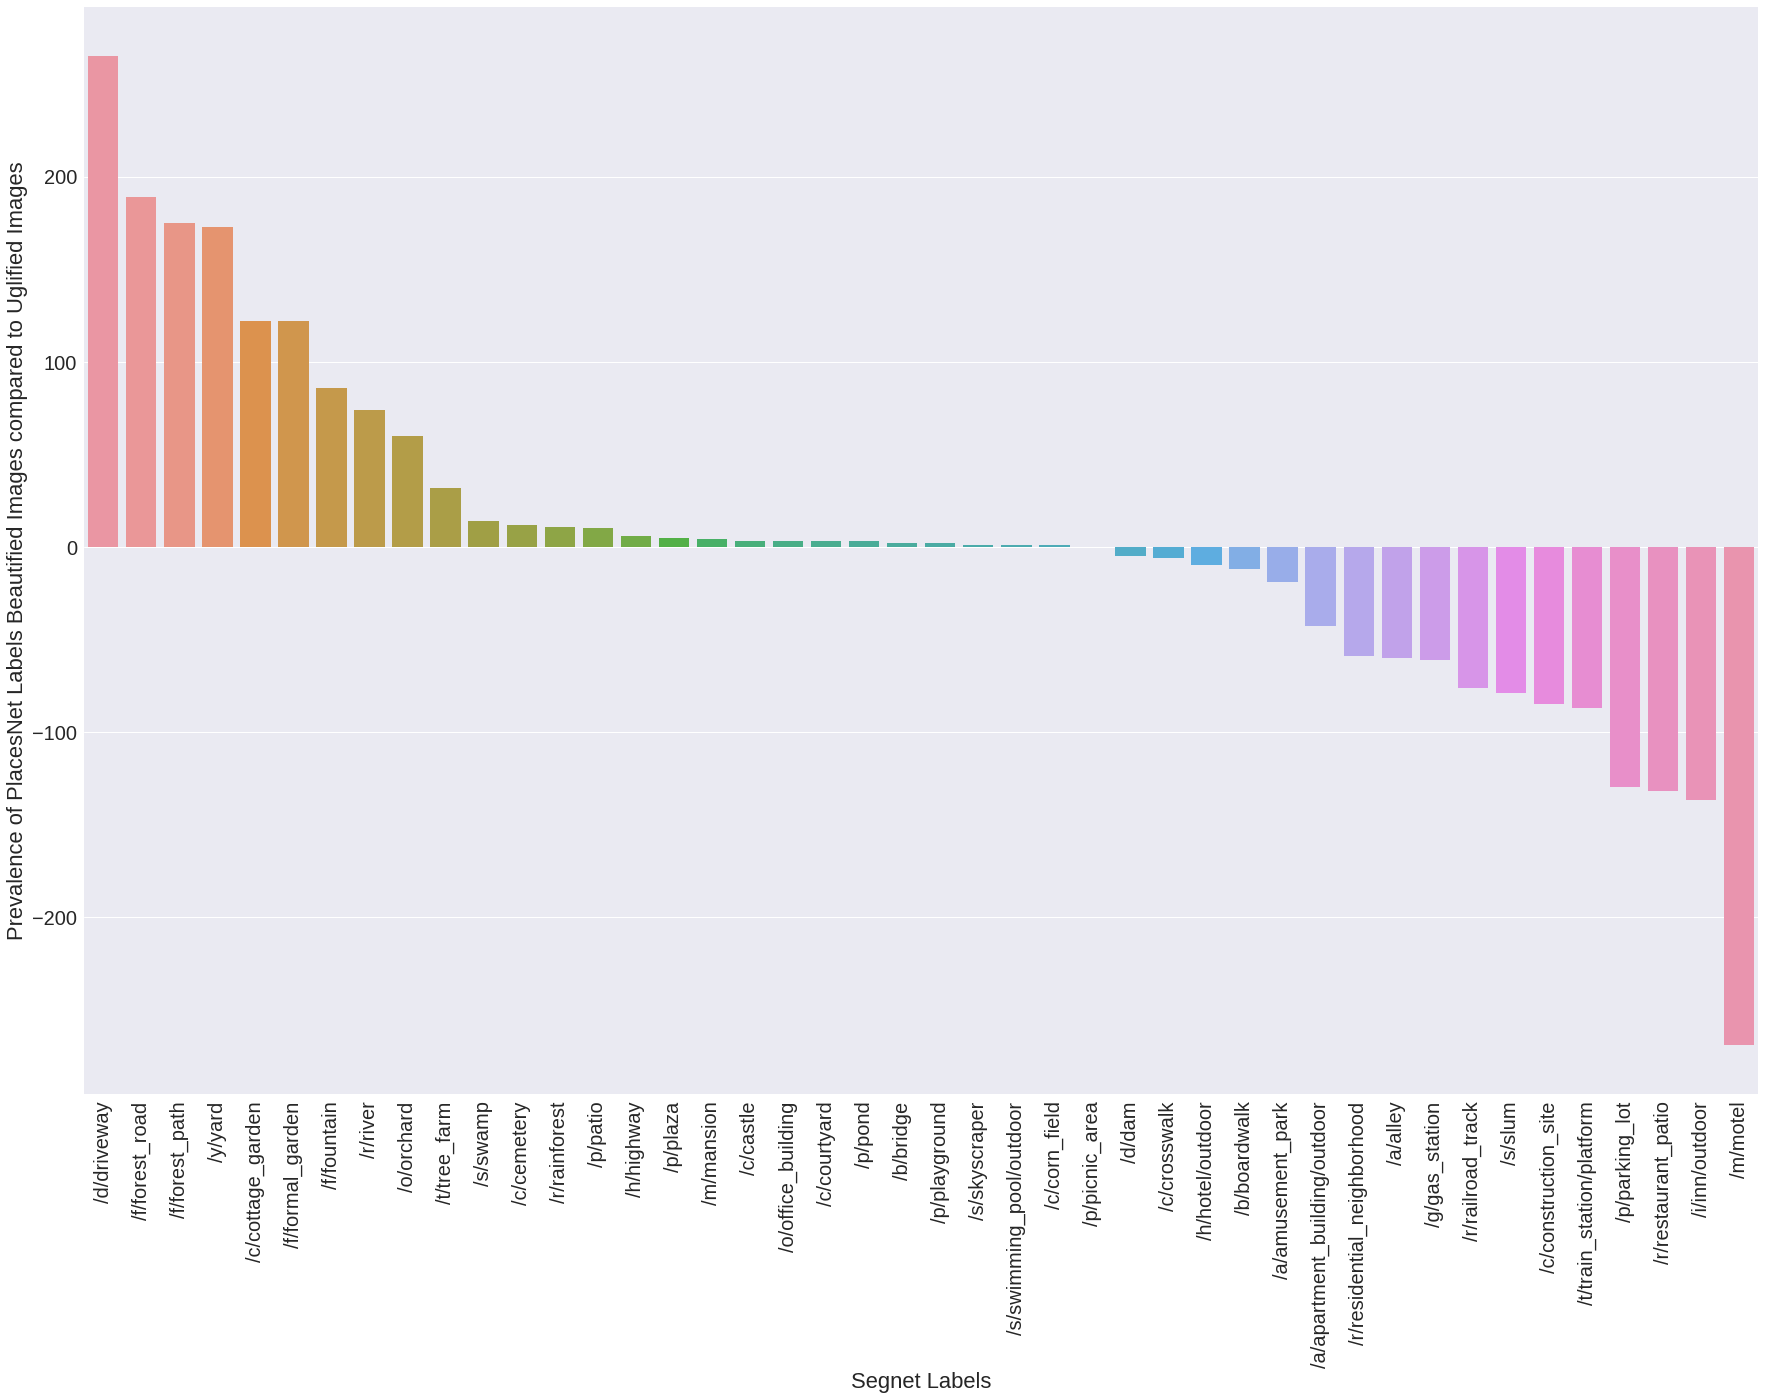

In [282]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=4) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='Segnet Labels', ylabel='Prevalence of PlacesNet Labels Beautified Images compared to Uglified Images')

In [ ]:
## Do some texture analysis

In [ ]:
textureDf = {}
textureLabels = ['Building', 'Road', 'Sky', 'Tree' ]
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    textureDf[retreivedDf[k]['key']] = {}
    textureDf[retreivedDf[k]['key']]['act'] = xformact
    textureDf[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']]['texture'])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['top5'] = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:  
            if l in testSegnetLabels.keys():
                deltas[retreivedDf[k]['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(testSegnetLabels[l]['segnetLabels'].flatten())) , denom))
                
    
    